---
title: "Efficient batch inference for LLMs with vLLM + UV Scripts on HF Jobs"
description: "Generate responses for thousands of dataset prompts using Qwen/Qwen3-30B-A3B-Instruct-2507 across 4 GPUs with automatic prompt filtering and tensor parallelism"
author: "Daniel van Strien"
categories: ["huggingface", "uv-scripts", "vllm", "hf Jobs"]
image: https://github.com/davanstrien/blog/blob/a2ff89fbd48d22e0f4a984b03a81a92c07080eea/posts/2025/hf-jobs/assets/is-this-uv-script.jpg?raw=true
---

Recently, we launched HF Jobs, a new way to run jobs on the Hugging Face platform. This post will show you how to use it to run large language model inference jobs with vLLM and uv Scripts, processing thousands of prompts with models that don't fit on a single GPU.

HF Jobs can be a very powerful tool for running a variety of compute jobs but I think it's particularly useful for running LLMS for batched infernece workloads where it can make a lot of sense to try and bring the data close to the model (to remove the latency of transferring data via an API) and to use trhe powerful auto batching features of vLLM to get the most out of your GPUs. 

## The Challenge

Large language models like Qwen3-30B-A3B-Instruct (30 billion parameters) exceed single GPU memory limits. Running batch inference on datasets requires:
- Multi-GPU setup with tensor parallelism
- Handling prompts that exceed context limits
- Managing dependencies and environment setup

Traditional approaches involve complex Docker setups, manual dependency management, and custom scripts for GPU coordination. HF Jobs changes this.

## What is vLLM?

vLLM is a very well known and heavily used inference engine. It is known for its ability to scale inference for LLMs. While we can use vLLM via an OpenAI compatible API, it also has a powerful batch inference mode that allows us to process large datasets of prompts efficiently. This "offline inference" is particularly useful when we want to generate responses for a large number of prompts without the overhead of API calls.


## What are uv Scripts?

UV scripts are Python scripts with inline dependency metadata that automatically install and manage their requirements. Instead of separate `requirements.txt` files or complex setup instructions, everything needed to run the script is declared in the script itself:

```python
  # /// script
  # requires-python = ">=3.10"
  # dependencies = [
  #     "vllm",
  #     "transformers",
  #     "datasets",
  # ]
  # ///

  # Your Python code here
```
When you run uv run script.py, UV automatically creates an isolated environment, installs dependencies, and executes your code. No virtual env setup, no pip install commands, no version conflicts.

## The Solution: UV Scripts + vLLM + HF Jobs

HF Jobs provides managed GPU infrastructure. This is already very useful but combined with uv Scripts we can more easily distribute scripts for a variety of ML/AI tasks in a (more) reproducible way.

![](https://raw.githubusercontent.com/davanstrien/blog/a2ff89fbd48d22e0f4a984b03a81a92c07080eea/posts/2025/hf-jobs/assets/is-this-uv-script.jpg)

## The `uv scripts` Hugging Face org

Since I'm so excited about uv Scripts, I created a Hugging Face org to host them: [uv scripts](https://huggingface.co/uv-scripts). This org will contain a variety of uv Scripts that you can use to run jobs on HF Jobs. For this example we'll use a script that allows us to run inference for a model using vLLM. This script exposes a bunch of parameters that allow you to control how the inference is run, including the model to use, the number of GPUs to use, and the batch size etc. 

In this case, the script expects as input a dataset with a column containing the input prompts (as messages). It will then run inference on the model using vLLM and return the generated responses in a new dataset. 

I'm personally quite excited to see people sharing more uv scripts for things that are not complex enough to justify a full repository but that are still useful to share and run on the Hugging Face platform!

If you are curious, you can check out the script [here](https://huggingface.co/datasets/uv-scripts/vllm/raw/main/generate-responses.py) or below:

In [ ]:
# | code-fold: true
import requests

print(requests.get("https://huggingface.co/datasets/uv-scripts/vllm/raw/main/generate-responses.py").text)

# /// script
# requires-python = ">=3.10"
# dependencies = [
#     "datasets",
#     "flashinfer-python",
#     "huggingface-hub[hf_transfer]",
#     "torch",
#     "transformers",
#     "vllm>=0.8.5",
# ]
#
# ///
"""
Generate responses for prompts in a dataset using vLLM for efficient GPU inference.

This script loads a dataset from Hugging Face Hub containing chat-formatted messages,
applies the model's chat template, generates responses using vLLM, and saves the
results back to the Hub with a comprehensive dataset card.

Example usage:
    # Local execution with auto GPU detection
    uv run generate-responses.py \\
        username/input-dataset \\
        username/output-dataset \\
        --messages-column messages

    # With custom model and sampling parameters
    uv run generate-responses.py \\
        username/input-dataset \\
        username/output-dataset \\
        --model-id meta-llama/Llama-3.1-8B-Instruct \\
        --temperature 0.9 \\
        --top-p 0.95 \\
       

## An example: Running Qwen3-30B-A3B-Instruct to generare summaries of datasets from 2025 

As an example, let's run Qwen3-30B-A3B-Instruct to generate summaries of datasets from 2025. We'll use the `hf-jobs` Python API to create a job that runs a uv Script on 4 GPUs with vLLM. First we'll quickly prepare the dataset and prompts. We'll use Polars + datasets to load the dataset and filter it down to the 2025 datasets. 

In [1]:
from huggingface_hub import snapshot_download

In [2]:
snapshot_download(
    repo_id="librarian-bots/dataset_cards_with_metadata",
    local_dir="data",
    repo_type="dataset",
    allow_patterns=["*.parquet"],
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

'/Users/davanstrien/Documents/daniel/blog/posts/2025/hf-jobs/data'

We'll do some filtering to focus on datasets where the cards are not super long or super short. We'll also filter to focus on datasets with at least one like and ten downloads. 

In [3]:
import polars as pl

In [4]:
df = pl.scan_parquet("data/**/*.parquet")

In [5]:
df.collect_schema()

Schema([('datasetId', String),
        ('author', String),
        ('last_modified', String),
        ('downloads', Int64),
        ('likes', Int64),
        ('tags', List(String)),
        ('task_categories', List(String)),
        ('createdAt', String),
        ('trending_score', Float64),
        ('card', String)])

In [6]:
df = df.filter(pl.col("card").str.len_chars() > 200)
df = df.filter(pl.col("downloads") > 2)
df = df.filter(pl.col("likes") > 1)

We make sure we have datetime for the createdAt column so we can filter by year. 


In [7]:
df = df.with_columns(pl.col("createdAt").str.to_datetime())

In [8]:
from datetime import datetime

this_year = datetime.now().year
this_year

2025

In [9]:
df_2025 = df.filter(pl.col("createdAt").dt.year() == this_year)

Since we're using the LazyFrame API, we can use the `collect` method to execute the query and get the results we get a nice optimized query plan. This is very nice since you can be quite lazy in how you filter and transform the data and Polars will optimize the query for you!

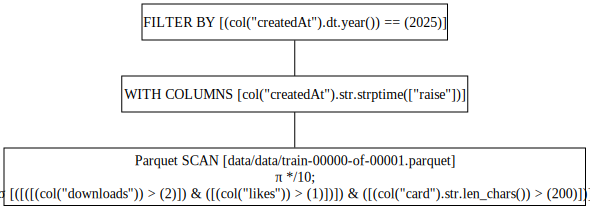

In [10]:
df_2025.show_graph(optimized=True, engine="streaming")

Polars and datasets play nicely together so we can easily convert between the two. Since we've done all the filtering we want, we can convert the Polars DataFrame to a Datasets Dataset.

In [11]:
from datasets import Dataset

In [12]:
ds = Dataset.from_polars(df_2025.collect())

In [13]:
ds

Dataset({
    features: ['datasetId', 'author', 'last_modified', 'downloads', 'likes', 'tags', 'task_categories', 'createdAt', 'trending_score', 'card'],
    num_rows: 2419
})

We'll do one more filter to remove datasets that don't have a card. We could also do this in Polars but since the `huggingface_hub` library has a nice way of converting a string into a dataset card where we can seperate the YAML from the main content, we'll do it using the `datasets` library and the `filter` function.

In [14]:
from huggingface_hub import DatasetCard

In [15]:
def is_short_card(row, min_length=200):
    card = DatasetCard(row['card']).text
    return len(card) > min_length

In [16]:
ds = ds.filter(is_short_card, num_proc=4)

Filter (num_proc=4):   0%|          | 0/2419 [00:00<?, ? examples/s]

### Preparing the prompts

Since the uv + vLLM script expecets as input a list of prompts, we'll convert the dataset to a list of prompts. We'll use the `map` function to create a list of prompts that we can use for inference. We'll use the `card` field of the dataset to create a prompt that asks the model to summarize the dataset.



In [17]:
def format_prompt_for_card(row, max_length=8000):
    card = DatasetCard(row['card']).text
    datasetId = row['datasetId']
    return f"""You are a helpful assistant that provides concise summaries of dataset cards for datasets on the Hugging Face Hub.
The Hub ID of the dataset is: {datasetId}.
The dataset card is as follows:
{card[:max_length]}]
Please write a one to two sentence summary of the dataset card.
The summary should be concise and informative, capturing the essence of the dataset.
The summary should be in English.
The goal of the summary is to provide a quick overview of the dataset's content and purpose. 
This summary will be used to help users quickly understand the dataset and as input for creating embeddings for the dataset card.
    """

In [18]:
print(format_prompt_for_card(ds[0]))

You are a helpful assistant that provides concise summaries of dataset cards for datasets on the Hugging Face Hub.
The Hub ID of the dataset is: agentlans/high-quality-multilingual-sentences.
The dataset card is as follows:
# High Quality Multilingual Sentences

- This dataset contains multilingual sentences derived from the [agentlans/LinguaNova](https://huggingface.co/datasets/agentlans/LinguaNova) dataset.
- It includes 1.58 million rows across 51 different languages, each in its own configuration.

Example row (from the `all` config):
```json
{
    "text": "امام جمعه اصفهان گفت: میزان نیاز آب شرب اصفهان ۱۱.۵ متر مکعب است که تمام استان اصفهان را پوشش میدهد و نسبت به قبل از انقلاب یکی از پیشرفتها در حوزه آب بوده است.",
    "fasttext": "fa",
    "gcld3": "fa"
}
```

Fields:
- **text**: The sentence in the original language.
- **fasttext**, **gcld3**: Language codes determined using fastText and gcld3 Python packages.

## Configurations

Each individual language is available as a separ

In [19]:
def create_messages(row):
    return {"messages": [
        {
            "role": "user",
            "content": format_prompt_for_card(row),
        },
    ]}

In [20]:
ds = ds.map(create_messages, num_proc=4)

Map (num_proc=4):   0%|          | 0/2082 [00:00<?, ? examples/s]

In [21]:
ds

Dataset({
    features: ['datasetId', 'author', 'last_modified', 'downloads', 'likes', 'tags', 'task_categories', 'createdAt', 'trending_score', 'card', 'messages'],
    num_rows: 2082
})

We remove columns we don't need

In [22]:
ds = ds.remove_columns([c for c in ds.column_names if c not in ['messages', 'datasetId']])

And push to the Hub!



In [23]:
ds.push_to_hub("davanstrien/cards_with_prompts")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  13%|#2        |  526kB / 4.13MB            

README.md:   0%|          | 0.00/391 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/davanstrien/cards_with_prompts/commit/8e32c041eba4fbf1729e3f5a4d1536365185f7d2', commit_message='Upload dataset', commit_description='', oid='8e32c041eba4fbf1729e3f5a4d1536365185f7d2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/davanstrien/cards_with_prompts', endpoint='https://huggingface.co', repo_type='dataset', repo_id='davanstrien/cards_with_prompts'), pr_revision=None, pr_num=None)

::: {.callout-note}
Hugging Face recently moved most of the backend storage to `Xet`. The tl;dr of this is that it means that datasets are deduplicated at a much more granular level, this makes working with datasets which change regularly much more efficient. See [](https://huggingface.co/docs/hub/en/storage-backends#xet) for more details. This combined with Jobs could make for a very powerful combination for running jobs on datasets that change frequently.
:::

## Launching our job

We now have the dataset with the prompts we want to use for inference. 

The interface for Jobs should look familiar if you've used Docker before. We can use Jobs via CLI or Python API. Via the CLI a basic command to run a job looks like this:

```bash
hf jobs run python:3.12 python -c "print('Hello from the cloud!')"
```

There is also an experimental uv command thaty allows us to run uv scripts directly:

```bash
hf jobs uv run script-url
```

As an example, we can run another simple script from the uv scripts org and just print the help for the script:

In [ ]:
hf jobs uv run https://huggingface.co/datasets/uv-scripts/deduplication/raw/main/semantic-dedupe.py --help

/Users/davanstrien/Library/Application Support/uv/tools/huggingface-hub/lib/python3.13/site-packages/huggingface_hub/utils/_experimental.py:60: UserWarning: 'HfApi.run_uv_job' is experimental and might be subject to breaking changes in the future without prior notice. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
Job started with ID: 688a31096dcd97e42f8095e7
View at: https://huggingface.co/jobs/davanstrien/688a31096dcd97e42f8095e7
Installed 50 packages in 116ms
usage: semantic-dedupekDOpug.py [-h] [--split SPLIT]
                                [--method {duplicates,outliers,representatives}]
                                [--threshold THRESHOLD]
                                [--batch-size BATCH_SIZE]
                                [--max-samples MAX_SAMPLES] [--private]
                                [--hf-token HF_TOKEN]
                                dataset column output_repo

Deduplicate a dataset us

You'll see that uv takes care of installing the dependencies and running the script. This is very convenient since we don't have to worry about setting up a virtual environment or installing dependencies manually. This can also be very nice if you want to share a script with others and want to help them avoid getting stuck in dependency hell.

We can also run hf jobs via the Python API. This is very convenient if you want to run jobs programmatically or if you want to integrate Jobs into your existing Python code (i.e. to run one step that requires a GPU and another step that doesn't).

## Running our inference job via huggingface_hub library

We can use the `huggingface_hub` library to run our inference job using `run_uv_job`

We'll grab a token to pass to our job 

In [31]:
from huggingface_hub import HfApi, get_token


HF_TOKEN = get_token()

We'll create an instance of the `HfApi` class and use the `run_uv_job` method to run our job. We'll pass the URL of the script we want to run, the dataset we want to use, and the parameters we want to use for the job.

In [32]:
api = HfApi()

Let's see what the `run_uv_job` method looks like:



In [33]:
?api.run_uv_job

Signature:
api.run_uv_job(
    script: 'str',
    *,
    script_args: 'Optional[List[str]]' = None,
    dependencies: 'Optional[List[str]]' = None,
    python: 'Optional[str]' = None,
    image: 'Optional[str]' = None,
    env: 'Optional[Dict[str, Any]]' = None,
    secrets: 'Optional[Dict[str, Any]]' = None,
    flavor: 'Optional[SpaceHardware]' = None,
    timeout: 'Optional[Union[int, float, str]]' = None,
    namespace: 'Optional[str]' = None,
    token: 'Union[bool, str, None]' = None,
    _repo: 'Optional[str]' = None,
) -> 'JobInfo'
Docstring:
Run a UV script Job on Hugging Face infrastructure.

Args:
    script (`str`):
        Path or URL of the UV script.

    script_args (`List[str]`, *optional*)
        Arguments to pass to the script.

    dependencies (`List[str]`, *optional*)
        Dependencies to use to run the UV script.

    python (`str`, *optional*)
        Use a specific Python version. Default is 3.12.

    image (`str`, *optional*, defaults to "ghcr.io/astral-s

we can use the `run_uv_job` method to run our job. We'll pass the URL of the script we want to run, the dataset we want to use, and the parameters we want to use for the job. These parameters will be passed to the script as command line arguments. Since we're using vLLM, we'll pass the vllm Docker image. This will mean that our job is run in this Docker container. 

::: {.callout-note}
This Docker image already has uv installed but if you want to use an image + uv for an image without uv insalled you'll need to make sure uv is installed first. You can also not specify any image and hf jobs will use the default UV image which has uv installed. This will work well in many cases but for LLM inference libraries which can have quite specific requirements, it can be useful to use a specific image that has the library installed.
:::

We can now run our job using the `run_uv_job` method. This will start the job and return a job object that we can use to monitor the job's progress.

In [ ]:
job = api.run_uv_job(
    script="https://huggingface.co/datasets/uv-scripts/vllm/raw/main/generate-responses.py",
    script_args=[
        "davanstrien/cards_with_prompts",  # Dataset with prompts
        "davanstrien/test-generated-responses",  # Where to store the generated responses
        "--model-id",  # Model to use for inference
        "Qwen/Qwen3-30B-A3B-Instruct-2507",  # Model to use for inference
        "--gpu-memory-utilization",  # GPU memory utilization
        "0.9",
        "--max-tokens",  # Maximum number of tokens
        "900",
        "--max-model-len",  # Maximum model length
        "8000",
    ],
    flavor="l4x4",  # What hardware to use
    image="vllm/vllm-openai:latest",  # Docker image to use
    secrets={"HF_TOKEN": HF_TOKEN},  # Pass as secret``
    env={"UV_PRERELEASE": "if-necessary"},  # Pass as env var
)

/Users/davanstrien/Documents/daniel/blog/.venv/lib/python3.12/site-packages/huggingface_hub/utils/_experimental.py:60: UserWarning: 'HfApi.run_uv_job' is experimental and might be subject to breaking changes in the future without prior notice. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(


We can get a url for our job, this will give us a page where we can monitor the job's progress and see the logs (**note** this won't URL won't work for you unless you run this job yourself).

In [35]:
print(f"Job URL: {job.url}")

Job URL: https://huggingface.co/jobs/davanstrien/688a33391c97bc486de2a232


![](https://github.com/davanstrien/blog/blob/1338b6009e211353489fcc50267a4d9e5d4632a9/posts/2025/hf-jobs/assets/jobs-dashboard.png?raw=true)

We can also print the status of the job

In [36]:
job.status

JobStatus(stage='RUNNING', message=None)

There are also a bunch of other attributes from the job that can be useful when running jobs as part of a larger workflow. For example, we can get the job's creation time, the job's status etc.

In [ ]:
job.created_at

datetime.datetime(2025, 7, 30, 14, 59, 5, 648000, tzinfo=datetime.timezone.utc)

In [38]:
job.flavor

'l4x4'

In [40]:
job.command

['uv',
 'run',
 'https://huggingface.co/datasets/uv-scripts/vllm/raw/main/generate-responses.py',
 'davanstrien/cards_with_prompts',
 'davanstrien/test-generated-responses',
 '--model-id',
 'Qwen/Qwen3-30B-A3B-Instruct-2507',
 '--gpu-memory-utilization',
 '0.9',
 '--max-tokens',
 '900',
 '--max-model-len',
 '8000']

We can also grab the logs

In [41]:
api.fetch_job_logs(
    job_id=job.id,
)

<generator object HfApi.fetch_job_logs at 0x1612df4c0>

This returns a generator, let's turn it into a list so we can print out a few examples of the logs

In [ ]:
print(
    list(
        api.fetch_job_logs(
            job_id=job.id,
        )
    )[:-10]
)  # Print the last 10 lines of logs

We can also see the resulting dataset for the job [here](https://huggingface.co/datasets/davanstrien/test-generated-responses) or below. You can see we have the original prompts and the generated responses.

<iframe
  src="https://huggingface.co/datasets/davanstrien/test-generated-responses/embed/viewer/default/train"
  frameborder="0"
  width="100%"
  height="560px"
></iframe>